In [459]:
"""
def encode_cirq(image):
    circuit = cirq.Circuit()
    mean_img = np.mean(image)
    binary_img = (J<mean_img).astype(int)
    states = {}
    for i in range(len(binary_img)):
        string = ''
        for ele in np.array(A[i])[0]:
            string+=ele.astype(str)
        if string not in states.keys():
            states[string] = 1
        else:
            states[string]+=1
    return states
encode_cirq(J)
"""

"\ndef encode_cirq(image):\n    circuit = cirq.Circuit()\n    mean_img = np.mean(image)\n    binary_img = (J<mean_img).astype(int)\n    states = {}\n    for i in range(len(binary_img)):\n        string = ''\n        for ele in np.array(A[i])[0]:\n            string+=ele.astype(str)\n        if string not in states.keys():\n            states[string] = 1\n        else:\n            states[string]+=1\n    return states\nencode_cirq(J)\n"

In [462]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

#this simulate a circuit (without measurement) and output results in the format of histogram.
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    print(result.get_counts(circuit))
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')

In [463]:
J

matrix([[0.        , 0.00127643],
        [0.        , 0.0023837 ]])

In [464]:
sample_img = np.matrix(images[0])
cols = [j for j in range(0,28,15)]
rows = [j for j in range(0,28,15)]
J = sample_img[:,cols][rows,:]


In [465]:
def encode_qiskit(image):
    from qiskit import QuantumCircuit
    img_arr = np.asarray(image).reshape(-1)
    desired_state = img_arr
    q = qiskit.QuantumRegister(4)
    circuit = qiskit.QuantumCircuit(q)
    i=0
    for ele in desired_state:
        circuit.rx(100*ele,i)
        i+=1
    circuit.decompose().draw()
    return circuit

In [452]:
encode_qiskit(J).draw()

┌───────┐   
q45_0: ───┤ Rx(0) ├───
       ┌──┴───────┴──┐
q45_1: ┤ Rx(0.12764) ├
       └──┬───────┬──┘
q45_2: ───┤ Rx(0) ├───
       ┌──┴───────┴──┐
q45_3: ┤ Rx(0.23837) ├
       └─────────────┘

{'0000': 0.981851924738177, '0010': 0.00401016185008, '1000': 0.014080405042394, '1010': 5.750836935e-05}
0000 0010
0.004010161850079632 0.9818519247381771 0.12764321414840446 2
0000 1000
0.014080405042393671 0.9818519247381771 0.2383698577470203 0
0010 1010
1000 1010
1.0


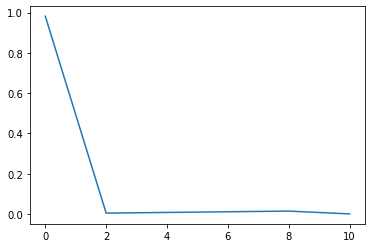

In [470]:

n = len(images)
mse=0
gatecount=0

#encode image into circuit
circuit=encode_qiskit(J)
    
#simulate circuit
histogram=simulate(circuit)
    
#count the number of 2-qubit gates
gatecount+=count_gates(circuit)[2]
    
#reconstruct the image
image_re=decode(histogram)
    
#calculate mse
mse+=image_mse(np.asarray(J),image_re)
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))


lists = sorted(histogram.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [472]:
def decode(histogram):    
    options = {}
    hist_keys = list(histogram.keys())
    for i in range(4):
        options[i]=0
    for i in range(len(histogram)):
        for j in range(i,len(histogram)):
            x = i^j
            if x and (not(x & (x-1))):
                val1 = bin(hist_keys[i])[2:].zfill(4)
                val2 = bin(hist_keys[j])[2:].zfill(4)
                for k in range(4):
                    if val1[k]!=val2[k]:
                        if options[3-k] ==0:                            
                            options[3-k] = 2*np.arctan(np.sqrt(histogram[hist_keys[j]]/histogram[hist_keys[i]]))
            else:
                continue
    image = []
    for i in range(4):
        image.append(options[i]/100)
    return np.asarray(image).reshape((2,2))
decode(histogram)

array([[0.        , 0.00127643],
       [0.        , 0.0023837 ]])

In [376]:
J

matrix([[0.        , 0.00127643],
        [0.        , 0.0023837 ]])